In [8]:
# LOAD THE REQUIEREMENTS 

# I checked warnings, but for the final report I prefer ignore those 
#that really does not affect the results (warnings of libraries, etc)
import warnings
warnings.simplefilter('ignore')

# Load the functions that are necessary for the task

#python
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datatable as dt

#Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython

#R
#---
#%R source('utils/Rgraphs.R')
# check if the packages are installed: if not: install and load, else: load 
%R source('utils/install_load_libraries.R') 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


value,[RTYPES.VECSXP]
visible,[RTYPES.LGLSXP]


In [9]:
# LOAD DATA with data.tables in python
import os
path = os.getcwd()

## **CLOUD OF TEXT DATA**

In [10]:
%%R -i path -o data
set.seed(1)

data <-readRDS(paste0(path, "/data/max_ent.RDS"))

data <- as.data.table(data)
data <- data[!is.na(text), ]
data <- data[, created := as.Date(created, '%Y-%m-%d')][, text := as.character(text)]
data <- data[, .(text, created,  id, screenName, retweetCount)]

removeURL <- function(x) gsub("http[^[:space:]]*", "", x)
remove_users <- function(x) gsub("@[^[:space:]]*", "", x)
removeNumPunct <- function(x) gsub("[^[:alpha:][:space:]]*", "", x)
data$web   <- str_extract(data$text, "http[^[:space:]]*")
data$text <- removeURL(data$text)
data$text <- remove_users(data$text)
data$text <- removeNumPunct(data$text)
data$text <-  gsub("RT", "", data$text)
data$text <-  gsub("   ", "", data$text)
data$text <-  gsub("\n", "", data$text)
data$text <-  gsub("\"", "", data$text)

data$text <- stripWhitespace(data$text)
data <- data[, key := paste0(text, '-', created, '-', id, '-', screenName)][!duplicated(key), ][, key := NULL]
data <- data[, nchar_val := nchar(text, allowNA = T)][, text := as.character(text)]
data <- data[, text2 := toupper(text)]
data <- data[nchar_val > 60, ][!is.na(nchar_val), ][, c('nchar_val') := NULL][, x := .N, by = text]

data  <- data[order(created, web),][, retweetCount := max(x, retweetCount), by = text]


data    <- data[, text2 := substr(text, 1, 30)]
data$text <- iconv(data$text, 'UTF-8', 'ASCII')
data$text2 <- iconv(data$text2, 'UTF-8', 'ASCII')
data  <- data[, text2 := toupper(text2)]
data <- data[, is.dup := duplicated(text2)]
data <- data[, is.dup_web := duplicated(web)]
data <- data[order(created), ][, created := as.character(created)]
 data.2 <-data[is.dup_web == F,][, created := 'all'] 

data.tab <- rbind(data.2, data)
data <- data[, created := as.Date(created)]

   shannon    michael    entropy    maximum fahrenheit  dangerous 
      2323        637        447        444        366        323 
NULL


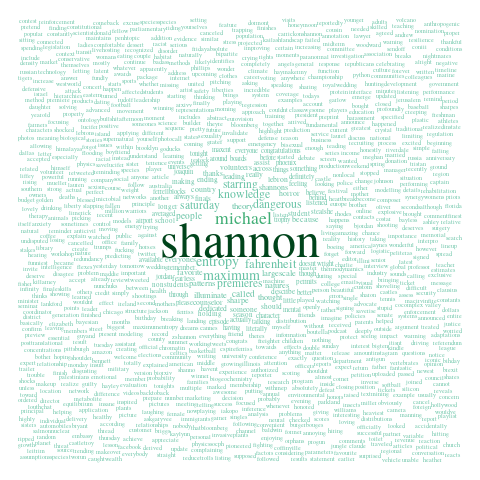

In [11]:
%%R -i data -o word.freq
require(tm)
myCorpus <- Corpus(VectorSource(data$text))
myCorpus <- tm_map(myCorpus, content_transformer(tolower))
tdm <- TermDocumentMatrix(myCorpus,
                          control = list(wordLengths = c(1, Inf)))
m <- as.matrix(tdm)
list <- which(nchar(rownames(m)) < 6)
m <- m[-list, ]
# calculate the frequency of words and sort it by frequency
word.freq <- sort(rowSums(m), decreasing = T)
print(head(word.freq))
# colors
pal <- brewer.pal(9, "BuGn")[-(1:4)]

require(wordcloud)
H <- wordcloud(words = names(word.freq), freq = word.freq, min.freq = 3, family = "serif",
          random.order = F, colors = pal, fixed.asp = F, rot.per = 0)

H

In [12]:
%%R -o word.freq
length(word.freq)

[1] 7611
